# WEI and xWEI cacluation
12 May 2022, Paul Voit, voit@uni-potsdam.de
Copyright (c) 2021-, Paul Voit
Creative Commons Attribution 4.0 International License

This notebook shows the the necessary code to compute WEI and xWEI for the methods cellwise GEV, ROI and dGEV for one examplary event:
Center of the Event: Braunsbach
CatRaRE ID: 16058
Start: 29 May 2016, 12:50
End: 30 May 2016, 06:50

Basic requirement is an array that captures the event spatially and temporarily with rainfall values in the temporal resolution of at least the minimum duration (01 h). This can be derived from the RADKLIM datasets. To allow for a moving window for every duration through every hour of the event, the array needs to extend to the left and to the right to allow for aggregation of the rainfall without creating missing values. For example: If the maximum regarded duration is 72 hours. The array needs to padded with 36 hours before the beginning of the event and 35 hours after the end of the event.
As the GEV and dGEV parameters were calculated with the R-packages "extReme"(Gilleland and Katz, 2016) and "IDF" (Ulrich et al., 2019) they are supplied here. Their calculation is  is based on the yearly maxima for each duration ("data/yearmax_2001_2020").

In [1]:
import xwei_functions as xf
import xarray as xr

In [2]:
#check final path solution
event = xr.open_dataset("data/event_16058_200.nc")['rainfall_amount']
path2gev_parms = "data/gev_parameters"
path2dgev_parms = "data/dgev_parameters"
path2roi_parms = "data/roi_parameters"

durations = ['01', '02', '04', '06', '12', '24', '48', '72']

Plot the event

In [ ]:
event.plot(x="x", y="y", col="time", col_wrap=3, robust=True)

# Cellwise GEV
**First step**: WEI calculation based on extreme value statistics with the GEV-distribution. Return periods are calculated using the GEV distribution.

In [4]:
max_eta_gev = xf.eta_gev(event, path2gev_parms, durations)
wei = max_eta_gev.max().max()
print(f"WEI: {wei} [ln(year)km]")

09:30:32: Calculating Eta for duration 01h.
09:30:33: Calculating Eta for duration 02h.
09:30:33: Calculating Eta for duration 04h.
09:30:33: Calculating Eta for duration 06h.
09:30:33: Calculating Eta for duration 12h.
09:30:33: Calculating Eta for duration 24h.
09:30:33: Calculating Eta for duration 48h.
09:30:34: Calculating Eta for duration 72h.
Total execution time: 0:00:01.913350
WEI: 185.96 [ln(year)km]


**Second Step**: With the resulting Eta  values for every duration we can now calculate the xWEI. The interpolation of the surface can take up to one hour. With the "precision"-variable we can speed up the process by aggregation but will result in less accurate results. This way less points have to be interpolated. The xWEI values in the publication are based on "precision=1", for testing precision can be set to 5, which will calculate the results within one minute.

 Note: If the spatial domain does not change and many events have to be calculated this process can be sped up significantly by using pre-calculated weights as described here (https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids)

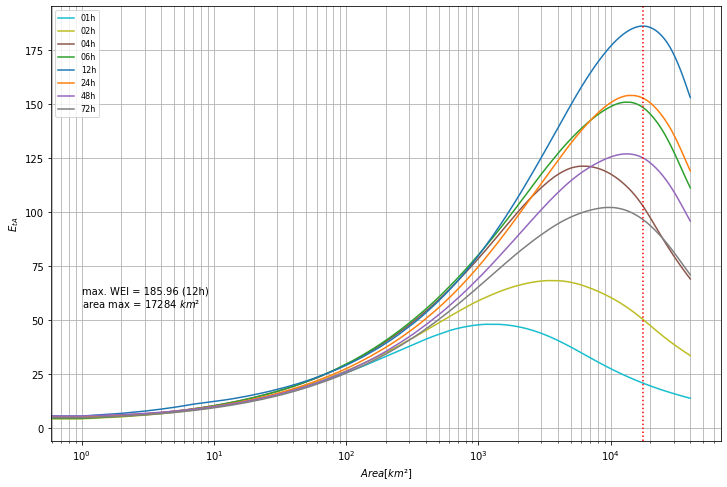

In [5]:
xf.plot_eta(max_eta_gev)

## Calculate the xWEI
With the Eta-curves calculated we can now calculate the xWEI. The interpolation of the surface can take some time. The resolution can be set down via the "precision"-parameter but this will lead to slightly different results. In the publication "precision" was set to "1". This calculation can take up to 20 min. For test purposes "precision=5" is recommend. This will take approximately one minute to calculate. If many events with high precision have to be calculated it is possible to speed up the process by saving the interpolation weights and vertices once and reuse them for every calculation. This is not included in this examplary code.

You can choose between precision levels 1 (highest precision) to 35 (lowest precision)


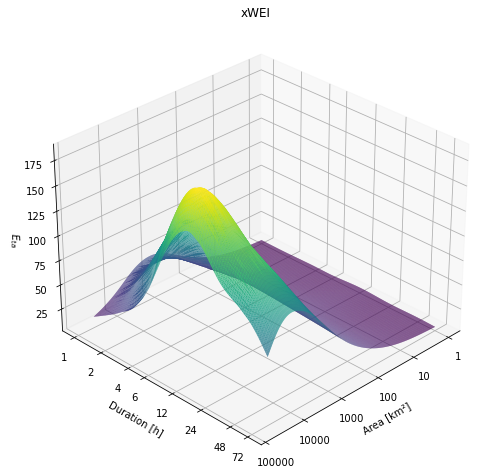

xWEI: 2366.592 [-]


In [6]:
xwei = xf.calc_xwei(max_eta_gev, precision=5, show_plot=True)
print(f"xWEI: {xwei} [-]")

# Duration dependent GEV - dGEV

In [7]:
max_eta_dgev = xf.eta_dgev(event, path2dgev_parms, durations)
wei = max_eta_dgev.max().max()
print(f"WEI: {wei} [ln(year)km]")

09:32:37: Calculating WEI for duration 01h.
09:32:37: Calculating WEI for duration 02h.
09:32:38: Calculating WEI for duration 04h.
09:32:38: Calculating WEI for duration 06h.
09:32:38: Calculating WEI for duration 12h.
09:32:38: Calculating WEI for duration 24h.
09:32:38: Calculating WEI for duration 48h.
09:32:38: Calculating WEI for duration 72h.
Total execution time: 0:00:01.417792
WEI: 176.11 [ln(year)km]


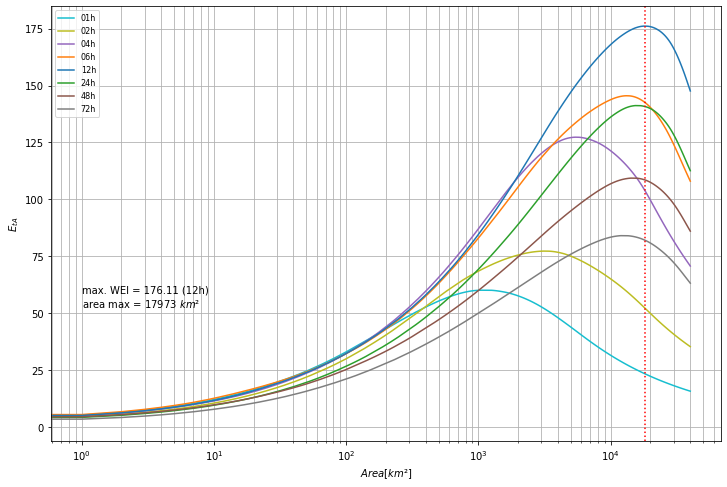

In [8]:
xf.plot_eta(max_eta_dgev)

You can choose between precision levels 1 (highest precision) to 35 (lowest precision)


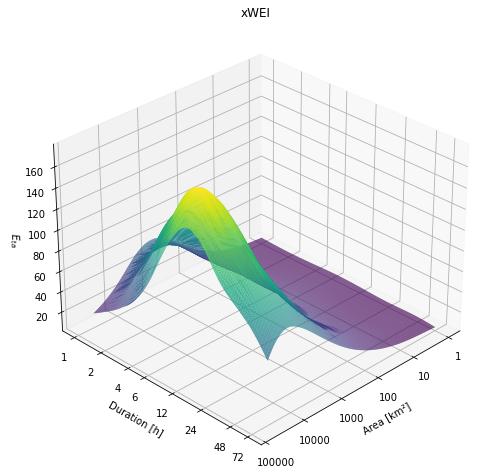

xWEI: 2361.219 [-]


In [9]:
xwei = xf.calc_xwei(max_eta_dgev, precision=5, show_plot=True)
print(f"xWEI: {xwei} [-]")

# Region of Interest
The parameters are calculated according to Burn (1990). For every cell we defined the surounding pixels in a 19 x 19 area as neighbors. The user has to specify a weighing function which defines how much the influence of neighboring decreases with increasing distance. We used follwoing formula: $$mu=1-(\frac{d}{26})$$ with *d* as the distance to be weighted. More information can be found in the Jupyter Notebook "roi_parameter_fits.ipynb".
Sometimes, when calculating the Eta-ROI numpy throws a runtime warning which can be ignored. This happens when there is there is the root of a negative number calculated, which should probably not happen. This returns `nan`. Because of this and because we can't check the timeseries of every pixel, we think, that the ROI parameter calculation is less reliable than the other methods. These warnings just occur sometimes, create "nan" among the return periods and can be ignored. Despite these inconsistencies the results achieved with this method are very similar to the results achieved with the other methods.



In [10]:
max_eta_roi = xf.eta_roi(event, path2roi_parms, durations)
wei = max_eta_roi.max().max()
print(f"WEI: {wei} [ln(year)km]")

09:33:12: Calculating WEI for duration 01h.
09:33:12: Calculating WEI for duration 02h.
Stop


/home/voit/Radolan/paper_repo/xwei_functions.py:248: RuntimeWarning: invalid value encountered in power
  rp_array = 1 / (-np.exp(-(-a + 1) ** (1 / locals()[f"g_{duration}"])) + 1)
/home/voit/Radolan/paper_repo/xwei_functions.py:254: RuntimeWarning: invalid value encountered in power
  test = 1 / (-np.exp(-(-a[i, :, :] + 1) ** (1 / locals()[f"g_{duration}"])) + 1)
/home/voit/Radolan/paper_repo/xwei_functions.py:248: RuntimeWarning: invalid value encountered in power
  rp_array = 1 / (-np.exp(-(-a + 1) ** (1 / locals()[f"g_{duration}"])) + 1)
/home/voit/Radolan/paper_repo/xwei_functions.py:254: RuntimeWarning: invalid value encountered in power
  test = 1 / (-np.exp(-(-a[i, :, :] + 1) ** (1 / locals()[f"g_{duration}"])) + 1)


09:33:12: Calculating WEI for duration 04h.
09:33:12: Calculating WEI for duration 06h.
09:33:12: Calculating WEI for duration 12h.
09:33:12: Calculating WEI for duration 24h.


/home/voit/Radolan/paper_repo/xwei_functions.py:248: RuntimeWarning: invalid value encountered in power
  rp_array = 1 / (-np.exp(-(-a + 1) ** (1 / locals()[f"g_{duration}"])) + 1)


09:33:13: Calculating WEI for duration 48h.
09:33:13: Calculating WEI for duration 72h.
Total execution time: 0:00:01.939871
WEI: 176.1 [ln(year)km]


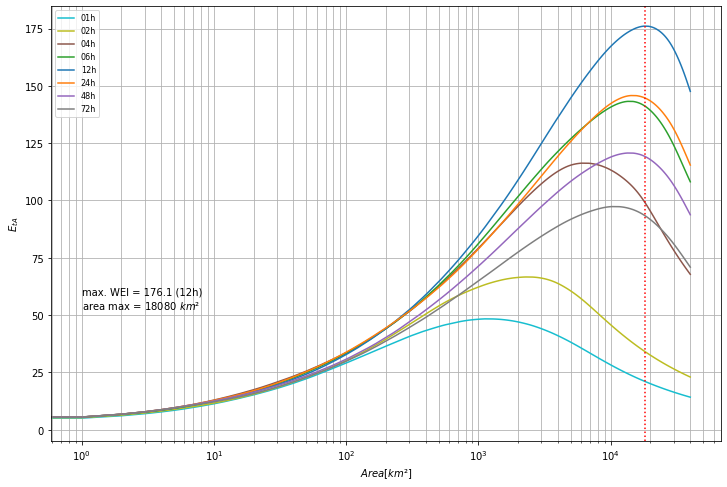

In [11]:
xf.plot_eta(max_eta_roi)

You can choose between precision levels 1 (highest precision) to 35 (lowest precision)


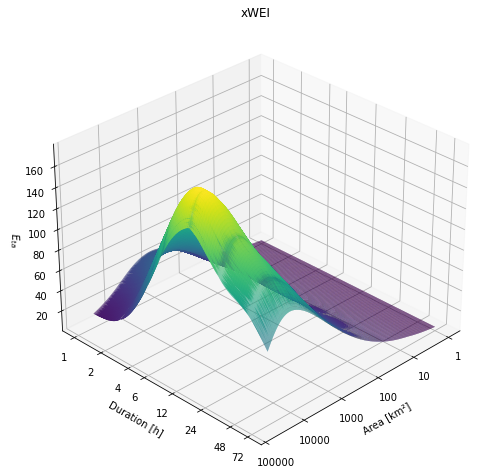

xWEI: 2350.253 [-]


In [12]:
xwei = xf.calc_xwei(max_eta_roi, precision=1, show_plot=True)
print(f"xWEI: {xwei} [-]")

The WEI and xWEI are quite similar for all three methods. The spatial scale of maximum extremeness is ~18,000 $km^2$ and the the event was most extreme for duration 12 h.